In [ ]:
!pip install torch torchvision torchaudio numpy pandas scipy scikit-learn librosa matplotlib tqdm datasets seaborn


In [ ]:
import os
import ast
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from datasets import load_dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve,
    precision_recall_curve
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [ ]:
dataset_hf = load_dataset("RS2002/WiFall")
print(dataset_hf)
print(dataset_hf["train"].column_names)


DatasetDict({
    train: Dataset({
        features: ['type', 'seq', 'timestamp', 'taget_seq', 'taget', 'mac', 'rssi', 'rate', 'sig_mode', 'mcs', 'cwb', 'smoothing', 'not_sounding', 'aggregation', 'stbc', 'fec_coding', 'sgi', 'noise_floor', 'ampdu_cnt', 'channel_primary', 'channel_secondary', 'local_timestamp', 'ant', 'sig_len', 'rx_state', 'len', 'first_word_invalid', 'data'],
        num_rows: 232941
    })
})
['type', 'seq', 'timestamp', 'taget_seq', 'taget', 'mac', 'rssi', 'rate', 'sig_mode', 'mcs', 'cwb', 'smoothing', 'not_sounding', 'aggregation', 'stbc', 'fec_coding', 'sgi', 'noise_floor', 'ampdu_cnt', 'channel_primary', 'channel_secondary', 'local_timestamp', 'ant', 'sig_len', 'rx_state', 'len', 'first_word_invalid', 'data']


In [ ]:
os.makedirs("wifall_data/fall", exist_ok=True)
os.makedirs("wifall_data/no_fall", exist_ok=True)

for i, row in enumerate(dataset_hf["train"]):
    label = row["taget"].lower()
    data_list = ast.literal_eval(row["data"])
    arr = np.array(data_list, dtype=np.float32)

    if label == "fall":
        np.save(f"wifall_data/fall/fall_{i}.npy", arr)
    else:
        np.save(f"wifall_data/no_fall/no_fall_{i}.npy", arr)


In [ ]:
class CSIDataset(Dataset):
    def __init__(self, root_dir, max_len=128):
        self.samples = []
        self.labels = []
        self.max_len = max_len
        self.label_map = {"no_fall": 0, "fall": 1}

        for label in ["no_fall", "fall"]:
            folder = os.path.join(root_dir, label)
            for f in os.listdir(folder):
                if f.endswith(".npy"):
                    self.samples.append(os.path.join(folder, f))
                    self.labels.append(self.label_map[label])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        data = np.load(self.samples[idx])

        if data.ndim == 1:
            data = np.expand_dims(data, axis=0)

        if data.shape[0] > data.shape[1]:
            data = data.T

        signal = data.mean(axis=0)

        if len(signal) < self.max_len:
            signal = np.pad(signal, (0, self.max_len - len(signal)))
        else:
            signal = signal[:self.max_len]

        S = np.abs(librosa.stft(signal, n_fft=64, hop_length=32))
        S = (S - S.mean()) / (S.std() + 1e-6)

        S = S.T.astype(np.float32)

        return torch.tensor(S), torch.tensor(self.labels[idx])


In [ ]:
dataset = CSIDataset("wifall_data")

train_idx, val_idx = train_test_split(
    list(range(len(dataset))),
    test_size=0.2,
    stratify=dataset.labels,
    random_state=42
)

train_ds = torch.utils.data.Subset(dataset, train_idx)
val_ds   = torch.utils.data.Subset(dataset, val_idx)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False)


In [ ]:
class BiGRUFallDetector(nn.Module):
    def __init__(self, input_dim=33, hidden_dim=128, num_layers=2):
        super().__init__()

        self.bigru = nn.GRU(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.3
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        _, h = self.bigru(x)
        h = torch.cat((h[-2], h[-1]), dim=1)
        return self.classifier(h)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BiGRUFallDetector().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
for epoch in range(1):
    model.train()
    epoch_loss = 0

    for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/100"):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_loss = 2154.695

    print(f"Train Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 1/80: 100%|██████████| 11647/11647 [07:28<00:00, 25.95it/s]


Train Loss: 0.4282


Epoch 2/80: 100%|██████████| 11647/11647 [07:21<00:00, 26.36it/s]


Train Loss: 0.3943


Epoch 3/80: 100%|██████████| 11647/11647 [06:47<00:00, 28.60it/s]


Train Loss: 0.3842


Epoch 4/80: 100%|██████████| 11647/11647 [06:50<00:00, 28.38it/s]


Train Loss: 0.3771


Epoch 5/80: 100%|██████████| 11647/11647 [06:51<00:00, 28.29it/s]


Train Loss: 0.3718


Epoch 6/80: 100%|██████████| 11647/11647 [06:49<00:00, 28.44it/s]


Train Loss: 0.3678


Epoch 7/80: 100%|██████████| 11647/11647 [06:43<00:00, 28.89it/s]


Train Loss: 0.3634


Epoch 8/80: 100%|██████████| 11647/11647 [06:43<00:00, 28.87it/s]


Train Loss: 0.3600


Epoch 9/80: 100%|██████████| 11647/11647 [06:48<00:00, 28.55it/s]


Train Loss: 0.3561


Epoch 10/80: 100%|██████████| 11647/11647 [07:21<00:00, 26.40it/s]


Train Loss: 0.3527


Epoch 11/80: 100%|██████████| 11647/11647 [07:32<00:00, 25.76it/s]


Train Loss: 0.3498


Epoch 12/80: 100%|██████████| 11647/11647 [06:52<00:00, 28.25it/s]


Train Loss: 0.3461


Epoch 13/80: 100%|██████████| 11647/11647 [06:50<00:00, 28.37it/s]


Train Loss: 0.3431


Epoch 14/80: 100%|██████████| 11647/11647 [06:44<00:00, 28.78it/s]


Train Loss: 0.3387


Epoch 15/80: 100%|██████████| 11647/11647 [06:48<00:00, 28.52it/s]


Train Loss: 0.3367


Epoch 16/80: 100%|██████████| 11647/11647 [06:45<00:00, 28.72it/s]


Train Loss: 0.3330


Epoch 17/80: 100%|██████████| 11647/11647 [06:43<00:00, 28.88it/s]


Train Loss: 0.3292


Epoch 18/80: 100%|██████████| 11647/11647 [06:52<00:00, 28.26it/s]


Train Loss: 0.3261


Epoch 19/80: 100%|██████████| 11647/11647 [06:53<00:00, 28.15it/s]


Train Loss: 0.3233


Epoch 20/80: 100%|██████████| 11647/11647 [07:04<00:00, 27.46it/s]


Train Loss: 0.3205


Epoch 21/80: 100%|██████████| 11647/11647 [06:59<00:00, 27.75it/s]


Train Loss: 0.3179


Epoch 22/80: 100%|██████████| 11647/11647 [06:51<00:00, 28.28it/s]


Train Loss: 0.3154


Epoch 23/80: 100%|██████████| 11647/11647 [06:53<00:00, 28.17it/s]


Train Loss: 0.3129


Epoch 24/80: 100%|██████████| 11647/11647 [06:56<00:00, 27.99it/s]


Train Loss: 0.3103


Epoch 25/80: 100%|██████████| 11647/11647 [06:53<00:00, 28.20it/s]


Train Loss: 0.3067


Epoch 26/80: 100%|██████████| 11647/11647 [06:56<00:00, 27.94it/s]


Train Loss: 0.3051


Epoch 27/80: 100%|██████████| 11647/11647 [07:02<00:00, 27.54it/s]


Train Loss: 0.3032


Epoch 28/80: 100%|██████████| 11647/11647 [06:58<00:00, 27.86it/s]


Train Loss: 0.3007


Epoch 29/80: 100%|██████████| 11647/11647 [06:52<00:00, 28.22it/s]


Train Loss: 0.2980


Epoch 30/80: 100%|██████████| 11647/11647 [06:56<00:00, 27.94it/s]


Train Loss: 0.2946


Epoch 31/80: 100%|██████████| 11647/11647 [06:56<00:00, 27.97it/s]


Train Loss: 0.2936


Epoch 32/80: 100%|██████████| 11647/11647 [07:04<00:00, 27.45it/s]


Train Loss: 0.2914


Epoch 33/80: 100%|██████████| 11647/11647 [06:45<00:00, 28.70it/s]


Train Loss: 0.2896


Epoch 34/80: 100%|██████████| 11647/11647 [06:47<00:00, 28.57it/s]


Train Loss: 0.2852


Epoch 35/80: 100%|██████████| 11647/11647 [07:03<00:00, 27.52it/s]


Train Loss: 0.2842


Epoch 36/80: 100%|██████████| 11647/11647 [07:08<00:00, 27.16it/s]


Train Loss: 0.2816


Epoch 37/80: 100%|██████████| 11647/11647 [07:08<00:00, 27.20it/s]


Train Loss: 0.2802


Epoch 38/80: 100%|██████████| 11647/11647 [06:59<00:00, 27.76it/s]


Train Loss: 0.2777


Epoch 39/80: 100%|██████████| 11647/11647 [06:51<00:00, 28.29it/s]


Train Loss: 0.2759


Epoch 40/80: 100%|██████████| 11647/11647 [07:01<00:00, 27.65it/s]


Train Loss: 0.2738


Epoch 41/80: 100%|██████████| 11647/11647 [07:03<00:00, 27.50it/s]


Train Loss: 0.2725


Epoch 42/80: 100%|██████████| 11647/11647 [06:59<00:00, 27.78it/s]


Train Loss: 0.2692


Epoch 43/80: 100%|██████████| 11647/11647 [06:55<00:00, 28.01it/s]


Train Loss: 0.2687


Epoch 44/80: 100%|██████████| 11647/11647 [07:14<00:00, 26.78it/s]


Train Loss: 0.2658


Epoch 45/80: 100%|██████████| 11647/11647 [07:39<00:00, 25.33it/s]


Train Loss: 0.2639


Epoch 46/80: 100%|██████████| 11647/11647 [07:38<00:00, 25.42it/s]


Train Loss: 0.2609


Epoch 47/80: 100%|██████████| 11647/11647 [07:18<00:00, 26.58it/s]


Train Loss: 0.2602


Epoch 48/80: 100%|██████████| 11647/11647 [07:19<00:00, 26.48it/s]


Train Loss: 0.2588


Epoch 49/80: 100%|██████████| 11647/11647 [07:13<00:00, 26.88it/s]


Train Loss: 0.2561


Epoch 50/80: 100%|██████████| 11647/11647 [06:54<00:00, 28.08it/s]


Train Loss: 0.2541


Epoch 51/80: 100%|██████████| 11647/11647 [06:56<00:00, 27.98it/s]


Train Loss: 0.2529


Epoch 52/80: 100%|██████████| 11647/11647 [06:57<00:00, 27.88it/s]


Train Loss: 0.2508


Epoch 53/80: 100%|██████████| 11647/11647 [06:59<00:00, 27.74it/s]


Train Loss: 0.2505


Epoch 54/80: 100%|██████████| 11647/11647 [07:07<00:00, 27.23it/s]


Train Loss: 0.2489


Epoch 55/80: 100%|██████████| 11647/11647 [06:59<00:00, 27.79it/s]


Train Loss: 0.2462


Epoch 56/80: 100%|██████████| 11647/11647 [06:57<00:00, 27.93it/s]


Train Loss: 0.2442


Epoch 57/80: 100%|██████████| 11647/11647 [06:47<00:00, 28.58it/s]


Train Loss: 0.2434


Epoch 58/80: 100%|██████████| 11647/11647 [06:48<00:00, 28.49it/s]


Train Loss: 0.2407


Epoch 59/80: 100%|██████████| 11647/11647 [06:47<00:00, 28.56it/s]


Train Loss: 0.2395


Epoch 60/80: 100%|██████████| 11647/11647 [06:51<00:00, 28.27it/s]


Train Loss: 0.2384


Epoch 61/80: 100%|██████████| 11647/11647 [06:50<00:00, 28.38it/s]


Train Loss: 0.2361


Epoch 62/80: 100%|██████████| 11647/11647 [06:47<00:00, 28.57it/s]


Train Loss: 0.2344


Epoch 63/80: 100%|██████████| 11647/11647 [06:55<00:00, 28.04it/s]


Train Loss: 0.2334


Epoch 64/80: 100%|██████████| 11647/11647 [06:46<00:00, 28.65it/s]


Train Loss: 0.2319


Epoch 65/80: 100%|██████████| 11647/11647 [06:51<00:00, 28.31it/s]


Train Loss: 0.2298


Epoch 66/80: 100%|██████████| 11647/11647 [06:49<00:00, 28.47it/s]


Train Loss: 0.2291


Epoch 67/80: 100%|██████████| 11647/11647 [06:51<00:00, 28.30it/s]


Train Loss: 0.2266


Epoch 68/80: 100%|██████████| 11647/11647 [06:59<00:00, 27.76it/s]


Train Loss: 0.2257


Epoch 69/80: 100%|██████████| 11647/11647 [07:01<00:00, 27.63it/s]


Train Loss: 0.2239


Epoch 70/80: 100%|██████████| 11647/11647 [06:58<00:00, 27.82it/s]


Train Loss: 0.2228


Epoch 71/80: 100%|██████████| 11647/11647 [07:11<00:00, 26.97it/s]


Train Loss: 0.2213


Epoch 72/80: 100%|██████████| 11647/11647 [07:02<00:00, 27.54it/s]


Train Loss: 0.2195


Epoch 73/80: 100%|██████████| 11647/11647 [06:53<00:00, 28.14it/s]


Train Loss: 0.2194


Epoch 74/80: 100%|██████████| 11647/11647 [06:51<00:00, 28.28it/s]


Train Loss: 0.2176


Epoch 75/80: 100%|██████████| 11647/11647 [06:46<00:00, 28.63it/s]


Train Loss: 0.2165


Epoch 76/80: 100%|██████████| 11647/11647 [06:51<00:00, 28.29it/s]


Train Loss: 0.2150


Epoch 77/80: 100%|██████████| 11647/11647 [06:46<00:00, 28.62it/s]


Train Loss: 0.2136


Epoch 78/80: 100%|██████████| 11647/11647 [06:58<00:00, 27.82it/s]


Train Loss: 0.2118


Epoch 79/80: 100%|██████████| 11647/11647 [07:30<00:00, 25.87it/s]


Train Loss: 0.2118


Epoch 80/80: 100%|██████████| 11647/11647 [07:27<00:00, 26.05it/s]

Train Loss: 0.2108


In [ ]:
model.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for X, y in val_loader:
        X, y = X.to(device), y.to(device)
        out = model(X)

        probs = torch.softmax(out, dim=1)[:, 1]
        preds = torch.argmax(out, dim=1)

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

In [ ]:
acc = accuracy_score(y_true, y_pred) * 100
prec = precision_score(y_true, y_pred) * 100
rec = recall_score(y_true, y_pred) * 100
f1 = f1_score(y_true, y_pred) * 100

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn + fp) * 100
sensitivity = tp / (tp + fn) * 100
auc = roc_auc_score(y_true, y_prob) * 100

print("\n====== BiGRU Evaluation ======")
print(f"Accuracy     : {acc:.2f}%")
print(f"Precision    : {prec:.2f}%")
print(f"Recall       : {rec:.2f}%")
print(f"Specificity  : {specificity:.2f}%")
print(f"Sensitivity  : {sensitivity:.2f}%")
print(f"F1 Score     : {f1:.2f}%")
print(f"AUC          : {auc:.2f}%")



====== BiGRU Evaluation ======
Accuracy     : 87.93%
Precision    : 86.68%
Recall       : 89.68%
Specificity  : 86.18%
Sensitivity  : 89.68%
F1 Score     : 88.15%
AUC          : 95.08%


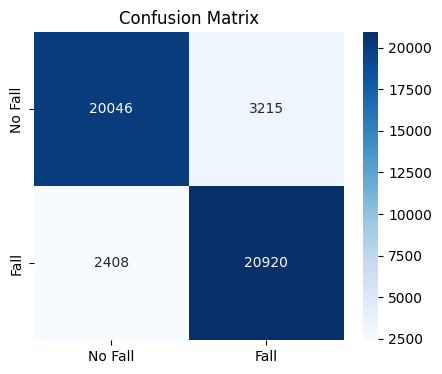

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Fall","Fall"],
            yticklabels=["No Fall","Fall"])
plt.title("Confusion Matrix")
plt.show()


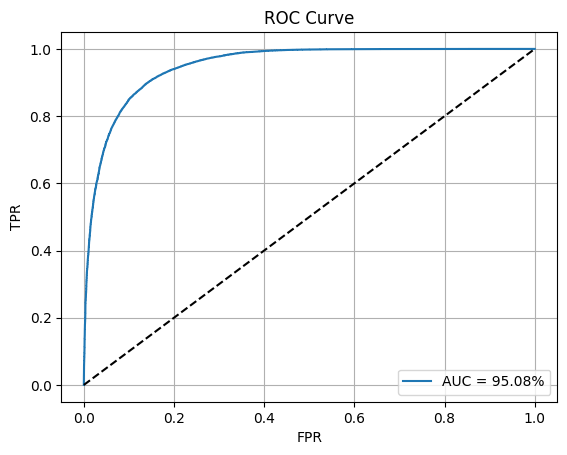

In [ ]:
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}%")
plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()
